# Top K retrieval model for recommending food recipes


## Introduction

In this analysis we will build a food recipe recommender system. We will build a user-item recommender system that can recommend recipes to users based on previous interactions. We will use collaborative filtering with implicit feedback where rated recipes are used as positive examples for a given user.
So given a user input ID, the system will return some recipe IDs that might be of interest to that user based on that user's rated recipes.


Recommender systems used in production typically consist of two phases:

1. The **retrieval stage** plays a crucial role in picking an initial set of several hundred candidates out of a vast pool of options. Its primary aim is to swiftly eliminate all candidates that fail to pique the user's interest. Given that the retrieval model might need to sift through millions of candidates, it must be computationally efficient.

2. The next stage is the **ranking stage**, which further fine-tunes the outputs from the retrieval model to identify the optimal few recommendations. It will further narrow down the list of candidates retrieved during the retrieval stage and create a (ranked) shortlist of candidates.

In this analysis we will focus on building a **retrieval model** that can used for the retrieval stage.

## Load Data

In [1]:
import os
import pprint
import sys
from ast import literal_eval
from typing import Dict, Text

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install tensorflow-recommenders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 3.1 MB/s eta 0:00:00


In [7]:
import tensorflow_recommenders as tfrs

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
BATCH_SIZE=1024
NROWS=10000

INTERACTIONS_RAW = '/content/drive/MyDrive/data/food_recipes/RAW_interactions.csv'
RECIPES_RAW = '/content/drive/MyDrive/data/food_recipes/RAW_recipes.csv'

### Download data

For this analysis we will the food recipe data set that was provided by **[Majumder et al]**. This dataset consists of 180K+ recipes and 700K+ recipe reviews covering 18 years of user interactions and uploads on Food.com. 

The dataset can be downloaded from https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions

For this proof-of-concept analysis we will only use the first 10000 user interactions and recipes in order to speed up the analysis.

In [10]:
NR_INTERACTIONS=len(pd.read_csv(INTERACTIONS_RAW, nrows=NROWS).dropna().index)
print(f"{NR_INTERACTIONS} reviews found")

9998 reviews found


In [11]:
# Download dataset using Kaggle CLI
# !kaggle datasets download shuyangli94/food-com-recipes-and-user-interactions

### Exploratory data Analysis

Recommender systems typically suffer from the 'long-tail' problem. This refers to the situation where a large number of items have very few interactions or ratings, while a small number of items have a large number of interactions or ratings. This leads to a skewed distribution of data, where the majority of the recommendations are focused on popular items, and the niche or less popular items are often neglected. This poses a challenge for recommender systems because they need to provide relevant recommendations to users for all items, not just the popular ones.

For our food recipe recommender system this would mean that a large fraction of recipes have received few ratings and a small fraction of recipes has received a high number of ratings.

When we plot the number of reviews per recipe using a density plot, we can see that the food recipes data set also exhibits the long-tail pattern.

In [12]:
counts_df = pd.read_csv(INTERACTIONS_RAW, nrows=NROWS)["recipe_id"].value_counts()

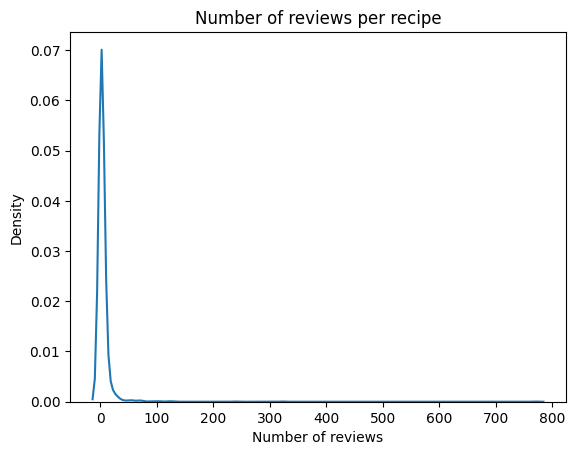

In [13]:
sns.kdeplot(counts_df)
plt.xlabel('Number of reviews')
plt.title('Number of reviews per recipe');


We can further zoom in and see that many reviews have 20 reviews or less, with a majority having received rating 0 or 1.

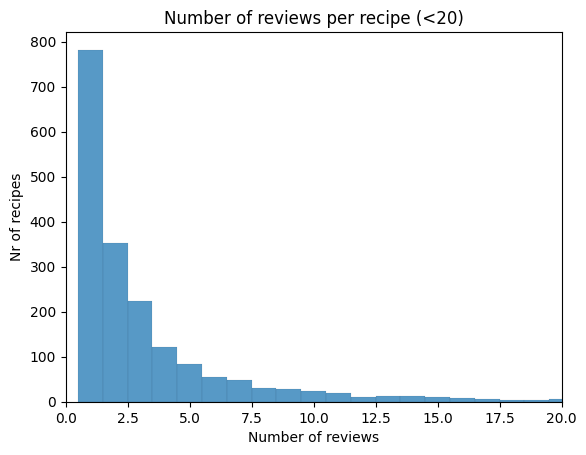

In [14]:
sns.histplot(
    counts_df,
    bins=800,
    discrete=True,
)
plt.xlabel('Number of reviews')
plt.ylabel('Nr of recipes')
plt.xlim(0,20)
plt.title('Number of reviews per recipe (<20)');

### Load item data (recipes)

We will load the recipe data into a Tensorflow data set and extract the `recipe_id` column. Note that the recipe IDs are imported as a string rather than an integer, which will become important when passing the values into the user model for our retrieval system.

In [15]:
def load_recipes(file_path=RECIPES_RAW, nrows=NROWS):
    """Load the recipes data into Tensorflow dataset

    Args:
        file_path (str, optional): path to csv file with recipes data.
        nrows (int, optional): nr of rows to import. Defaults to 1000.

    Returns:
        Tensorflow.dataset: Tensorflow dataset
    """
    recipes_df = pd.read_csv(
        file_path,
        usecols=["id", "name", "description", "tags", "steps", "ingredients"],
        nrows=nrows,
    )
    recipes_df["name"] = recipes_df["name"]
    recipes_df["tags"] = recipes_df["tags"].apply(literal_eval).str.join(" ")
    recipes_df["description"] = recipes_df["description"]
    recipes_df["ingredients"] = (
        recipes_df["ingredients"].apply(literal_eval).str.join(" ")
    )
    recipes_df["steps"] = recipes_df["steps"].apply(literal_eval).str.join(" ")
    recipes_df = recipes_df[
        ["id", "name", "tags", "description", "ingredients", "steps"]
    ]
    recipes_df.rename(columns={"id": "recipe_id"}, inplace=True)
    recipes_df["recipe_id"] = recipes_df["recipe_id"].astype(str)
    recipes_df.fillna("", inplace=True)
    recipes_ds = tf.data.Dataset.from_tensor_slices(dict(recipes_df))
    return recipes_ds

In [16]:
items_ds = load_recipes()
recipes_ds = items_ds.map(lambda x: {'recipe_id': x['recipe_id']})

In [17]:
for x in recipes_ds.take(5).as_numpy_iterator():
    pprint.pprint(x)

{'recipe_id': b'137739'}
{'recipe_id': b'31490'}
{'recipe_id': b'112140'}
{'recipe_id': b'59389'}
{'recipe_id': b'44061'}


### Load user data (rated recipes)

We wil alos load the user interacting data and extract columns `user_id` and `recipe_id`. Similarly as the recipe data, the user and recipe IDs are imported as strings rather than IDs.

In [18]:
def load_ratings(file_path=INTERACTIONS_RAW, nrows=NROWS):
    """Load ratings into Tensorflow dataset

    Returns:
        Tensorflow.dataset: Tensorflow dataset with ratings
    """

    ratings_df = pd.read_csv(
        file_path,
        usecols=["user_id", "recipe_id", "date", "rating", "review"],
        nrows=nrows,
    )

    ratings_df["user_id"] = ratings_df["user_id"].astype(str)
    ratings_df["recipe_id"] = ratings_df["recipe_id"].astype(str)
    ratings_df.fillna("", inplace=True)
    ratings_ds = tf.data.Dataset.from_tensor_slices(dict(ratings_df))
    return ratings_ds

In [21]:
ratings_ds = load_ratings()
users_ds = ratings_ds.map(
    lambda x: {"user_id": x['user_id'], "recipe_id": x['recipe_id']}
)

In [22]:
for x in users_ds.take(5).as_numpy_iterator():
    pprint.pprint(x)

{'recipe_id': b'40893', 'user_id': b'38094'}
{'recipe_id': b'40893', 'user_id': b'1293707'}
{'recipe_id': b'44394', 'user_id': b'8937'}
{'recipe_id': b'85009', 'user_id': b'126440'}
{'recipe_id': b'85009', 'user_id': b'57222'}


### Create train and test sets

We will shuffle the user interaction data and divide it into a training and test dataset using a 80/20 split. 

In [19]:
NR_TRAIN = int(np.floor(0.8 * NR_INTERACTIONS))
NR_TEST = NR_INTERACTIONS - NR_TRAIN

print(f"{NR_TRAIN} samples in train set")
print(f"{NR_TEST} samples in test set")

7998 samples in train set
2000 samples in test set


In [40]:
tf.random.set_seed(42)
shuffled_ds = users_ds.shuffle(NROWS, seed=42, reshuffle_each_iteration=False)

train_ds = shuffled_ds.take(NR_TRAIN)
test_ds = shuffled_ds.skip(NR_TRAIN).take(NR_TEST)

## Build Retrieval Model

For building a retrieval model, we will use a **two-tower model** as neural network architecture. The two-tower model is a type of neural network architecture that is commonly used in recommendation systems. It is so-called because it consists of two "towers" or branches of neural networks that process two different types of inputs.

The first tower is called the **user tower** (or query tower), and it takes in user-specific data, such as past behavior, and ratings history. The input data is typically represented as a sparse vector, where each entry corresponds to a particular feature or attribute of the user. The user tower maps this input vector into a lower-dimensional latent space, where each user is represented as a dense vector of continuous values.

The second tower is called the **item tower** (or candidate tower) and it takes in item-specific data, such as item descriptions, metadata, and attributes. The item tower similarly maps the input data into the same latent space as the user tower, where each item is represented as a dense vector of continuous values.

Once the user and item vectors are obtained, they are combined and passed through a final neural network layer to predict the user's preference or likelihood of interacting with the item. This can be done using a variety of techniques, such as dot product or cosine similarity between the user and item vectors.

The two-tower model is powerful because it allows for efficient processing of sparse and high-dimensional input data, while also enabling the learning of non-linear interactions between user and item features.

### Embedding dimensions

Before building the user and item models, we will get all unique user and recipe IDs, which will be used as fixed vocabularies for the `StringLookup` layer and are also necessary to determine the dimension of the subsequent `Embedding` layer.

In [24]:
recipe_ids = recipes_ds.batch(BATCH_SIZE).map(lambda x: x["recipe_id"])
rating_ids = ratings_ds.batch(BATCH_SIZE).map(lambda x: x["user_id"])

unique_recipe_ids = np.unique(np.concatenate(list(recipe_ids)))
unique_user_ids = np.unique(np.concatenate(list(rating_ids)))

print(f"Nr of unique recipes: {len(unique_recipe_ids)}")
print(f"Nr of unique users: {len(unique_user_ids)}")

Nr of unique recipes: 10000
Nr of unique users: 6451


In [25]:
embedding_dim = 32

### User tower

For the user tower we will build a user representation model which consists of two Keras layers: i.e. a `StringLookup` and an `Embedding` layer. The `StringLookup` layer is a preprocessing layer which maps string features (i.e. the user IDs) to integer indices. For creating the lookup indices, the unique user IDs are used as a fixed vocbulary, where each user ID in the vocabulary maps to a specific index. Those indices are then passed into the `Embedding` layer, which is a dense layer with a fixed dimensionality. We will also add $L2$ regularization to the embedding layer to reduce the risk of overfitting the model.

This user model can then be used as query model, which computes the query representation (i.e. fixed-dimensionality embedding vector) and passes the features to the next layer.

In [26]:
user_model = tf.keras.Sequential(
    [
        tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(
            # add 1 to embedding dimension to account for unknown tokens
            len(unique_user_ids) + 1, 
            embedding_dim,
            embeddings_regularizer=tf.keras.regularizers.L2(0.2)
        ),
    ]
)


### Item tower

Similarly as the user tower, we will build an item model for the recipes, which will map all recipe IDs into an fixed-size embedding.


Thiis item model will then be used as candidate model, which computes the candidate representation for the recipes (i.e. fixed-dimensionality embedding vector) and passes the features to the next layer.

In [27]:
item_model = tf.keras.Sequential(
    [
        tf.keras.layers.StringLookup(vocabulary=unique_recipe_ids, mask_token=None),
        tf.keras.layers.Embedding(
            # add 1 to embedding dimension to account for unknown tokens
            len(unique_recipe_ids) + 1,
            embedding_dim,
            embeddings_regularizer=tf.keras.regularizers.L2(0.2)
        ),
    ]
)

### Retrieval Model

We can now put eveything together into the a `TFRS model`. TFRS classes are derived from Tensorflow base classes that can be used to combine an item model, user model and retrieval task into a retrieval model. 

The retrieval task is an additional Keras layer that will be used as final layer to combine the user and item embeddings and compute the loss function and metrics.

The retrievavl task subsequently computes the `tfrs.metrics.FactorizedTopK metric` to compare candidate pairs and retrieve the top K candidates.

Essentially, the training dataset consists of pairs of positive (user ID, recipe ID) matches. To assess the efficacy of our model, we must compare the affinity score computed by the model for this pair against the scores of every other potential candidate pairs. If the score assigned to the positive pair surpasses that of all other candidates, it indicates high precision and accuracy in our model. 



In [28]:
class RetrievalModel(tfrs.Model):
    """Food recipe prediction model"""

    def __init__(self, user_model, item_model, batch_size=BATCH_SIZE):
        # Use init method from base class to set up model architecture.
        super().__init__()

        # Add recipe representations model
        self.item_model = item_model

        # Add user representation mdodel
        self.user_model = user_model

        # Set batch size
        self.eval_batch_size = batch_size

        # The task computes the loss and metrics
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=recipes_ds.map(lambda x: x["recipe_id"]).batch(self.eval_batch_size).map(self.item_model)
            )
        )


    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        
        # Get user features and pass them into the user model
        user_embeddings = self.user_model(features["user_id"])

        # Get recipe features and pass them into the recipe model
        item_embeddings = self.item_model(features["recipe_id"])

        # Compute the loss and the metrics.
        return self.task(user_embeddings, item_embeddings)


We can initialize the model using the previously defined user and item models. We will also add the `Adagrad` optimizer to train the retrieval model.

In [41]:
model = RetrievalModel(user_model, item_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

## Train retrieval model

We ca now fit the retrieval model on the training data.

In [42]:
cached_train_ds = train_ds.shuffle(NR_TRAIN).batch(BATCH_SIZE).cache()
cached_test_ds = test_ds.batch(BATCH_SIZE).cache()

In [43]:
history = model.fit(cached_train_ds, epochs=7)

Epoch 1/7
8/8 [==============================] - 8s 698ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1509 - factorized_top_k/top_5_categorical_accuracy: 0.1762 - factorized_top_k/top_10_categorical_accuracy: 0.1873 - factorized_top_k/top_50_categorical_accuracy: 0.2267 - factorized_top_k/top_100_categorical_accuracy: 0.2449 - loss: 6760.2523 - regularization_loss: 38.0576 - total_loss: 6798.3099
Epoch 2/7
8/8 [==============================] - 7s 940ms/step - factorized_top_k/top_1_categorical_accuracy: 0.5178 - factorized_top_k/top_5_categorical_accuracy: 0.5563 - factorized_top_k/top_10_categorical_accuracy: 0.5646 - factorized_top_k/top_50_categorical_accuracy: 0.5815 - factorized_top_k/top_100_categorical_accuracy: 0.5863 - loss: 6759.4039 - regularization_loss: 5.3024 - total_loss: 6764.7062
Epoch 3/7
8/8 [==============================] - 6s 738ms/step - factorized_top_k/top_1_categorical_accuracy: 0.8072 - factorized_top_k/top_5_categorical_accuracy: 0.8237 - factoriz

We can save the mobdel weights. These weights can be used to restore the trained model when deploying the retrieval model into production.

In [44]:
model.save_weights('/content/drive/MyDrive/projects/food_recsys/retrieval_model.weights.tf', save_format='tf')

In [ ]:
# The retrieval model can be loaded from the saved weight as follows:
#loaded_model = RetrievalModel(user_model, item_model)
#loaded_model.load_weights('/content/drive/MyDrive/projects/food_recsys/retrieval_model.weights.tf)

We can plot the loss and top K accuracy to assess training performance. We can see that loss is decreasing and accuracy is increasing during training.

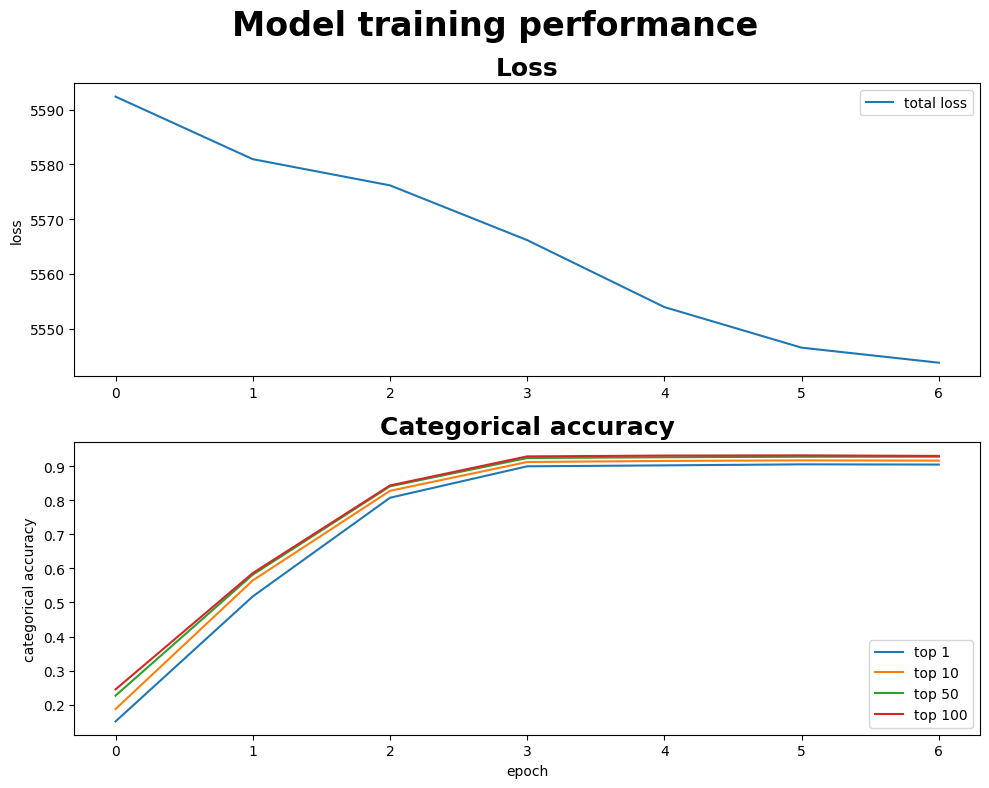

In [53]:
plt.subplots(1, 2, figsize=(10, 8))
plt.suptitle('Model training performance', fontsize=24, fontweight='bold')

plt.subplot(2, 1, 1)
plt.title('Loss', fontsize=18, fontweight='bold')
plt.ylabel('loss')
plt.plot(history.history['total_loss'])
plt.legend(['total loss'], loc='upper right')

plt.subplot(2, 1, 2)
plt.title('Categorical accuracy', fontsize=18, fontweight='bold')
plt.ylabel('categorical accuracy')
plt.plot(history.history['factorized_top_k/top_1_categorical_accuracy'])
plt.plot(history.history['factorized_top_k/top_10_categorical_accuracy'])
plt.plot(history.history['factorized_top_k/top_50_categorical_accuracy'])
plt.plot(history.history['factorized_top_k/top_100_categorical_accuracy'])
plt.xlabel('epoch')
plt.legend(['top 1', 'top 10', 'top 50', 'top 100'], loc='lower right')

plt.tight_layout()
plt.show();

## Evalutate retrieval model

Now that we have trained the retrieval model, we can evaluate model performance on the test set.

In [54]:
test_results = model.evaluate(cached_test_ds, return_dict=True)

2/2 [==============================] - 2s 491ms/step - factorized_top_k/top_1_categorical_accuracy: 0.6195 - factorized_top_k/top_5_categorical_accuracy: 0.6300 - factorized_top_k/top_10_categorical_accuracy: 0.6305 - factorized_top_k/top_50_categorical_accuracy: 0.6370 - factorized_top_k/top_100_categorical_accuracy: 0.6375 - loss: 6850.4225 - regularization_loss: 29.1792 - total_loss: 6879.6017


In [55]:
results_df = pd.DataFrame([{
  'top 1': test_results['factorized_top_k/top_1_categorical_accuracy'],
  'top 10': test_results['factorized_top_k/top_10_categorical_accuracy'],
  'top 50': test_results['factorized_top_k/top_50_categorical_accuracy'],
  'top 100':test_results['factorized_top_k/top_100_categorical_accuracy'],  
}])

results_df.T.rename(columns={0: 'categorical accuracy'})

,categorical accuracy
top 1,0.6195
top 10,0.6305
top 50,0.6370
top 100,0.6375


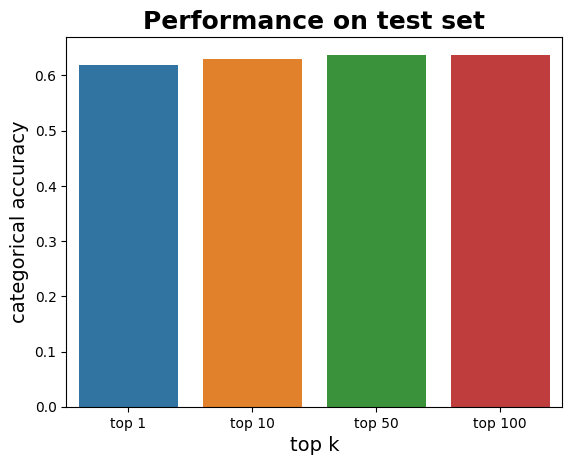

In [56]:
sns.barplot(results_df)

plt.title('Performance on test set', fontsize=18, fontweight='bold')
plt.xlabel('top k', fontsize=14)
plt.ylabel('categorical accuracy', fontsize=14);

We can observe that our retrieval model performs worse on the test set compared to the training set. than training performance. This is mainly due to the following two factors:

1. The model is overfitting because it is memorizing data that is has seen. Models with many parameters are prone to overfitting. We can mediate this by increasing the regularization in the embedding layers in the user and item models. We could also add an additional `Dropout` layer to both models.

2. The model is re-recommending recipes that some users already rated. These known positives can push out the new test recipes from the top K recommendations. This could be mitigated by removing previously seen recipes from the test dataste.

## Model predictions

We can now use the retrieval model to recommend recipe IDs for a given user ID.

To annotate the retrieved recipe IDs, we will create a lookup table which maps recipe IDs to their description. 

In [64]:
mapping_df = pd.read_csv(RECIPES_RAW, usecols=['name', 'id', 'description'])
mapping_df.head()

,name,id,description
0,arriba baked winter squash mexican style,137739,autumn is my favorite time of year to cook! th...
1,a bit different breakfast pizza,31490,this recipe calls for the crust to be prebaked...
2,all in the kitchen chili,112140,this modified version of 'mom's' chili was a h...
3,alouette potatoes,59389,"this is a super easy, great tasting, make ahea..."
4,amish tomato ketchup for canning,44061,my dh's amish mother raised him on this recipe...


Additionally we will still need to create an index for our dataset, which can then be used to retrieve the entires as predicted by the retrieval model.

In [65]:
def recommend_recipes(
    user_id,
    item_ds=recipes_ds,
    item_id='recipe_id',
    mapping_df=mapping_df,
    retrieval_model=model,
    nr_recommendations=10,
    batch_size=BATCH_SIZE
):
    index = tfrs.layers.factorized_top_k.BruteForce(
        retrieval_model.user_model, nr_recommendations
    )
    # Recommends recipes out of the entire recipe itemset.
    index.index_from_dataset(
        tf.data.Dataset.zip(
            (
                item_ds.map(lambda x: x[item_id]).batch(batch_size),
                item_ds.map(lambda x: x[item_id])
                .batch(batch_size)
                .map(retrieval_model.item_model),
            )
        )
    )

    # Get recommended recipes IDs from index
    _, ids = index(tf.constant([user_id]))
    id_list = ids[0:nr_recommendations].numpy().astype("int64").tolist()[0]

    # Annotate retrieved IDs with metadata
    return mapping_df[mapping_df["id"].isin(id_list)][["id", "name", "description"]]


We can now take a random user ID from the test set and recommend some recipe IDs, together with recipe name and description.

In [66]:
user_id = list(test_ds.take(100).as_numpy_iterator())[99]['user_id']
recommend_recipes(user_id = user_id, nr_recommendations=20).style.hide(axis="index")

id,name,description
232044,sangria fruit cups non alcoholic,a wonderful light dessert recipe from the people at kraft canada and adapted by me to be feed a few more. very tasty. (cooking time is refrigeration time)
446919,30 minute chili,"this chili tastes remarkably good and can be made for dinner when you are pressed for time. the recipe comes from the beefitswhatfordinner.com website, but i originally saw the recipe in the newpaper. i have made this several times, used whatever beef i had on hand. i've also added more beans and tomatoes to the same quantity of beef, and it still tasted great."
404323,a different porridge,from recipes+ magazine
229794,a very interesting smoked salmon sandwich,"an unusual combination of ingredients make a nice change as antony worrall thompson shares his recipe for a sublime open sandwich, piled high with smoked salmon, crispy bacon, cream cheese and more!"
171619,algerian cucumber salad,posted for the zaar world tour. a yummy salad!
213671,all bran pancake,healthy
131359,all in one warm artichoke bread dip,"this is called 'all in one', as the ingredients are all measured in ""ones"". a nice change from the standard spinach bread dip. great for parties. i also change the monterey jack cheese from time to time, trying farmer's cheese, mozzarella, havarti, (pretty much any mild white cheese will do!)"
295701,all purpose house seasoning,this is my very own all purpose seasoning blend that i use on a daily basis. will store on the counter up to 2 months. will keep in the freezer for up to 12 months. use anyplace you would use regular salt and pepper. feel free to experiment with your favorite dried herbs and spices. i also keep smaller batches (just split a recipe) on the counter with 1 strip of dried lemon and another with 1 strip of dried lime in it. simply peel a strip of the zest and leave it on the counter overnight to dehydrate it. i have yet another with dried mint in it.
201614,almond tea cookies,these easy crispy almond cookies are perfect with a cup of tea.
63426,american blessing mix,i found this on the net


## Bibliography

- **Majumder, Bodhisattwa Prasad, et al.** "Generating personalized recipes from historical user preferences." arXiv preprint arXiv:1909.00105 (2019).